```getOctaveFilterBank()``` gera um banco de filtros triangulares em escala logarítmica com "Nfpo" filtros por oitava. Retorna a s respostas em frequência dos fitros na matriz "H" bem como os valores das frequências centrais (vértice dos triângulos dos filtros).
 
Argumentos:
- ```fs```   - frequência de amostragem do sinal de áudio. (default: 16000)
- ```Nfft``` - Número de amostras da FFT (para amostrar a resposta em frequência dos filtros)(default=4096)
- ```Nfpo``` - Número de filtros por oitava (default: 12)
- ```fmin_user``` - frequência mínima que o utilizador propõe (default: 32.7032 Hz: C1)
- ```fmax_user``` - frequência máxima que o utilizador propõe (default: 7040 Hz:    A8)
- ```edges``` - string; se igual a 'edges', junta ao vetor de saída fcf, os vértices do 1º e último filtro.
           (default: eges='')
Saídas:
- H    - matriz de dimensão Nb x Nfft/2+1 com a parte positiva das respostas em frequência dos Nb filtros (um filtro por linha de H)
- fcf  - vetor com os vétices dos filtros. Se edges='edges' junta fmin e fmax: fcf=[fmin,fcf,fmax]

**Nota:** os filtros estão sobrepostos em frequência de forma que se fcf(i) for a frequência central do filtro i, é também o vértice superior do filtro i-1 e o vértice inferior do filtro i+1. <br>
A frequência fcf(i) é dada por: 
                               $$f(i) = f(0)\times2^{(i/Nfpo)},$$
de forma que f(0)=fmin, f(1) é a frequência central do 1º filtro, etc. f(Nfpo) = 2*f(0) e f(Nb+1)=fmax.

**Nota:** as frequências centrais são ajustadas, sempre que possível, aos semitons musicais na escala temperada. Daí que fmin_user é apenas indicativa e pode ser diferente de fmin. O mesmo para fmax.

Inicialmente é feito o cálculo do número de filtros (Nb) que o banco de filtros terá pelas frequências miníma (fmin_user) e máxima (fmax_user) dadas pelo utilizador e pelo número de filtros por oitava (Nfpo).
 
O primeiro filtro tem a frequência mínima (fmin), a primeira frequência central (f1).
 
A construção do Banco de Filtros dependerá de fi. Pelo que o primeiro valor de fi, será a frequência mínima do primeiro filtro que será
usado na aplicação do Banco de Filtros, a frequência seguinte no vetor fi será a frequência central (fcf) do primeiro filtro. A terceira frequência do vetor fi será a frequência alta do primeiro filtro. O segundo filtro terá como frequência mínima a frequência central do primeiro filtro e terá como frequência central a frequência mais alta do primeiro filtro.

% Respostas dos filtros
% 1          .
%           /|\
%          / |  \                    H(1,:)
% --------+  |   +--------------------------------->f
% 1    fmin  f1  .
%               /|\
%             /  |  \                H(2,:)
% -----------+   |   +----------------------------->f
%                f2
% ...
%                  1            .
%                             ´ | `
%                         ´     |    `      H(Nb,:)
%----------------------+        |        +--------->f
%                   f_Nb-1    f_Nb      fmax

 function [H,fcf]=getOctaveFilterBank(fs, Nfft, Nfpo, fmin_user, fmax_user, edges)
%function [H,fcf]=getOctaveFilterBank(fs, Nfft, Nfpo, fmin_user, fmax_user, edges)
%



	%default values:
	if nargin < 1
		fs=16000;
	end
	if nargin < 2
		Nfft=4096;
	end
	if nargin < 3
		Nfpo=12;
	end	
	if nargin < 4
		fmin_user= 440*2.^(((1+1)*12+0-69)/12);
	end	
	if nargin < 5
		fmax_user= 440*2.^(((8+1)*12+9-69)/12);
	end	
	if nargin < 6
		edges='';
	end	

	if fmax_user>fs/2
		fmax_user=fs/2;
	end


    %if(fmax_user<fs/2)
    %    disp('A frequência máxima tem de ser maior ou igual que metade da frequência de amostragem.');
    %    return;
    %end
    %Numero de linhas de H=Nb
    %size(H)=Nb*(Nfft/2+1)

    %fs=16e3; Nfft=4096; Nfpo=12; fmin_user=50; fmax_user=8e3;
    %fs=16e3; Nfft=4096; Nfpo=7; fmin_user=30; fmax_user=4.1860e3;
    %fs=16e3; Nfft=4096; Nfpo=2; fmin_user=50; fmax_user=8e3;

    i0=ceil(Nfpo*log2(fmin_user/440));
    %i0_indexes=i0+69; %69, Lá como referência

    fmin=440*2^(i0/Nfpo); %Freq. Low do 1ºfiltro - não conta
    
    i=floor(-i0+Nfpo*(log2(fmax_user/440)));
    Nb=i-1;
    fmax=440*2^((i+i0)/Nfpo);

    %f1=440*2^((i0+1)/Nfpo)
    

	i=0:Nb+1;
	fi = fmin*2.^(i/Nfpo);

    % fi=zeros(1,Nb+2);
    % %fi(1)=fmin;
    % for i=0:Nb+1
    %     fi(i+1)=440*2^((i0+i)/Nfpo);
    %     i=i+1;
    % end
    % %f(end)=fmax;

    
    %Construção do Banco de Filtros
    k=0:Nfft/2; f=k*fs/Nfft;
    H=zeros(Nb,Nfft/2+1);
    fcf=zeros(1, Nb);
    for j=1:Nb
        fLow=fi(j); fcf(j)=fi(j+1); fUpp=fi(j+2);

        H(j,:)= (f-fLow)/(fcf(j)-fLow).*(f>fLow & f<=fcf(j)) + ...
			    (f-fUpp)/(fcf(j)-fUpp).*(f>fcf(j)  & f<=fUpp);
    end


    %figure ;
    %plot(f,H)

    %figure ;
    %plot(f, sum(H))

    if nargout>1 && strcmp(edges,'edges')
        fcf=[fmin,fcf,fmax]; %edges
    end

end


In [8]:
import math
import numpy as np

In [9]:
fmin_user = 440 * 2 ** (((1 + 1) * 12 + 0 - 69) / 12)
i0 = np.ceil(12 * np.log2(fmin_user / 440))
fmin = 440 * 2 ** (i0 / 12)

In [10]:
fmin

32.70319566257483

In [7]:
440 * 2 ** (((1 + 1) * 12 + 0 - 69) / 12)

32.70319566257483

In [1]:
import numpy as np

def getOctaveFilterBank(fs=16000, Nfft=4096, Nfpo=12, fmin_user=None, fmax_user=None, edges=''):
    if fmin_user is None:
        fmin_user = 440 * 2 ** (((1 + 1) * 12 + 0 - 69) / 12)
    if fmax_user is None:
        fmax_user = 440 * 2 ** (((8 + 1) * 12 + 9 - 69) / 12)
    if edges == '':
        edges_flag = False
    else:
        edges_flag = True

    if fmax_user > fs / 2:
        fmax_user = fs / 2

    i0 = np.ceil(Nfpo * np.log2(fmin_user / 440))
    fmin = 440 * 2 ** (i0 / Nfpo)

    i = np.floor(-i0 + Nfpo * (np.log2(fmax_user / 440)))
    Nb = int(i - 1)
    fmax = 440 * 2 ** ((i + i0) / Nfpo)

    i = np.arange(Nb + 2)
    fi = fmin * 2 ** (i / Nfpo)

    H = np.zeros((Nb, Nfft // 2 + 1))
    fcf = np.zeros(Nb)

    k = np.arange(Nfft // 2 + 1)
    f = k * fs / Nfft

    for j in range(Nb):
        fLow = fi[j]
        fcf[j] = fi[j + 1]
        fUpp = fi[j + 2]

        H[j, :] = ((f - fLow) / (fcf[j] - fLow)) * ((f > fLow) & (f <= fcf[j])) + \
                  ((f - fUpp) / (fcf[j] - fUpp)) * ((f > fcf[j]) & (f <= fUpp))

    if edges_flag:
        fcf = np.concatenate(([fmin], fcf, [fmax]))

    return H, fcf

# Exemplo de uso:
# H, fcf = getOctaveFilterBank()
# print(H.shape)
# print(fcf)


In [2]:
H, fcf = getOctaveFilterBank()
print(H.shape)
print(fcf)

(92, 2049)
[  34.64782887   36.70809599   38.89087297   41.20344461   43.65352893
   46.24930284   48.9994295    51.9130872    55.           58.27047019
   61.73541266   65.40639133   69.29565774   73.41619198   77.78174593
   82.40688923   87.30705786   92.49860568   97.998859    103.82617439
  110.          116.54094038  123.47082531  130.81278265  138.59131549
  146.83238396  155.56349186  164.81377846  174.61411572  184.99721136
  195.99771799  207.65234879  220.          233.08188076  246.94165063
  261.6255653   277.18263098  293.66476792  311.12698372  329.62755691
  349.22823143  369.99442271  391.99543598  415.30469758  440.
  466.16376152  493.88330126  523.2511306   554.36526195  587.32953583
  622.25396744  659.25511383  698.45646287  739.98884542  783.99087196
  830.60939516  880.          932.32752304  987.76660251 1046.5022612
 1108.73052391 1174.65907167 1244.50793489 1318.51022765 1396.91292573
 1479.97769085 1567.98174393 1661.21879032 1760.         1864.65504607
 197

## Demo

/tmp/ipykernel_3476544/3186404775.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_orig, x = wavfile.read('Diatonic_scale_on_C.wav')


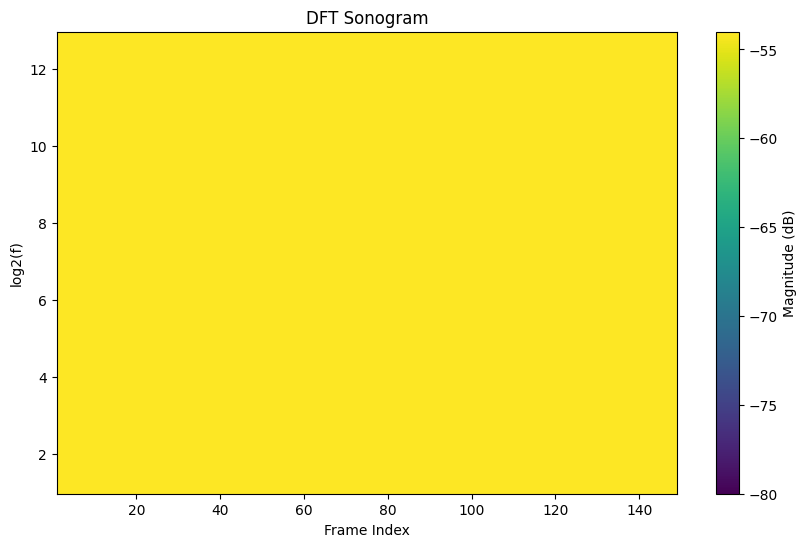

NameError: name 'getOctaveFilterBank' is not defined

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
from scipy.fft import fft
from scipy.ndimage import gaussian_filter

# Carregar o áudio
fs_orig, x = wavfile.read('Diatonic_scale_on_C.wav')

# Redimensionar a taxa de amostragem para 16000 Hz
fs = 16000
x16 = resample(x[:, 0], int(fs / fs_orig * len(x)), axis=0)

# Parâmetros de análise
N = 4096
M = 800
xframes = np.array([x16[i:i + N] for i in range(0, len(x16) - N + 1, M)])
Nframes = len(xframes)

# Sonograma DFT
Nfft = 2 ** int(np.ceil(np.log2(N)))
Xframes = fft(xframes, axis=1, n=Nfft)
Xframes = np.abs(Xframes[:, :Nfft // 2 + 1])
k = np.arange(Nfft // 2 + 1)
Delta = fs / Nfft
f = (k - 0.5) * Delta
f[0] = f[1] / 4
log2f = np.log2(f)
th = np.floor(np.max(np.max(np.log10(Xframes))) - 80)

# Plot do sonograma DFT
plt.figure(figsize=(10, 6))
plt.imshow(gaussian_filter(10 * np.log10(Xframes.T + 1e-10), (1, 1)), aspect='auto', origin='lower', cmap='viridis',
           extent=[1, Nframes, log2f[1], log2f[-1]], vmin=-80, vmax=th)
plt.colorbar(label='Magnitude (dB)')
plt.title('DFT Sonogram')
plt.xlabel('Frame Index')
plt.ylabel('log2(f)')
plt.show()

# CQT
H, fcf = getOctaveFilterBank(fs, Nfft, 12, 32, 4500, 'edges')
Nb = len(fcf) - 2

# Plot dos filtros
plt.figure(figsize=(10, 6))
for k in range(Nb):
    plt.plot([0, fcf[k], fcf[k + 1], fcf[k + 2], fs / 2], [0, 0, 1, 0, 0])
plt.xlabel('f [Hz]')
plt.ylim(-0.2, 1.2)
plt.title('Filters')
plt.show()

# Plot dos filtros em relação à frequência
plt.figure(figsize=(10, 6))
plt.plot(f, H.T)
plt.xlabel('f [Hz]')
plt.ylim(-0.2, 1.2)
plt.title('Filter Bank')
plt.show()

# Aplicação dos filtros
RMS = np.dot(H, Xframes.T)

# Plot do sonograma CQT
plt.figure(figsize=(10, 6))
th2 = np.floor(np.max(np.max(np.log10(RMS))) - 20)
plt.imshow(gaussian_filter(10 * np.log10(RMS + 1e-10), (1, 1)), aspect='auto', origin='lower', cmap='viridis',
           extent=[1, Nframes, fcf[1], fcf[-2]], vmin=-20, vmax=th2)
plt.colorbar(label='Magnitude (dB)')
plt.title('CQT Sonogram')
plt.xlabel('Frame Index')
plt.ylabel('f [Hz]')
plt.yscale('log')
plt.show()
